Markov Jump Process: Reaction Network
======================================

In the following, we fit stochastic chemical reaction kinetics with pyABC.

We consider the Markov jump process model $m_1$ for conversion of (chemical) species $X$ to species $Y$:


$$
   m_1: X \xrightarrow{k_1} Y.
$$

The model is equipped with a single rate parameter $k_1$.
To simulate the model, we define a simple Gillespie simulator:

In [1]:
import numpy as np

def h(x, pre, c):
    return (x**pre).prod(1) * c

def gillespie(x, c, pre, post, max_t):
    """
    Gillespie simulation
    Parameters
    ----------
    x: 1D array of size n_species. The initial numbers.
    c: 1D array of size n_reactions. The reaction rates.
    pre: array of size n_reactions x n_species
        What is to be consumed.
    post: array of size n_reactions x n_species. What is to be produced
    max_t: int. Timulate up to time max_t

    Returns
    -------
    t, X: 1d array, 2d array
        t: The time points.
        X: The history of the species.
           ``X.shape == (t.size, x.size)``
    """
    t = 0
    t_store = [t]
    x_store = [x.copy()]
    S = post - pre

    while t < max_t:
        h_vec = h(x, pre, c)
        h0 = h_vec.sum()
        if h0 == 0:
            break
        delta_t = np.random.exponential(1 / h0)
        # no reaction can occur any more
        if not np.isfinite(delta_t):
            t_store.append(max_t)
            x_store.append(x)
            break
        reaction = np.random.choice(c.size, p=h_vec/h0)
        t = t + delta_t
        x = x + S[reaction]

        t_store.append(t)
        x_store.append(x)

    return np.array(t_store), np.array(x_store)


Next, we define the model in terms of ther initial molecule numbers $x_0$, an array ``pre`` which determines what is to be consumed (the left hand side of the reaction equations) and an array ``post`` which determines what is to be produced (the right hand side of the reaction equations).
Moreover, we define that the simulation time should not exceed ``MAX_T`` seconds.

Model $m_1$ starts with initial concentrations $X=40$ and $Y=3$.
The reaction $m_1: X \xrightarrow{k_1} Y.$ is encoded in ``pre = [[1, 0]]`` and ``post = [[0, 1]]``.

In [116]:
MAX_T = 0.1

class Model_m1:
    __name__ = "Model 1"
    x0 = np.array([40, 3])   # Initial molecule numbers
    pre = np.array([[1, 0]], dtype=int)
    post = np.array([[0, 1]])
    scale = "log10"
    def __call__(self, par):
        if self.scale == "log10":
            rate = pow(10,par["rate"])
        elif self.scale == "linear":
            rate = par["rate"]
        t, X = gillespie(self.x0,
                         np.array(rate),
                         self.pre, self.post,
                         MAX_T)
        return {"t": t, "X" : X}


We add the option to use eaiter a log or linear scale for the inference problem

Then, we draw one stochastic simulation from model $m_1$ using the rate for k1= 1.5 in the log scale.

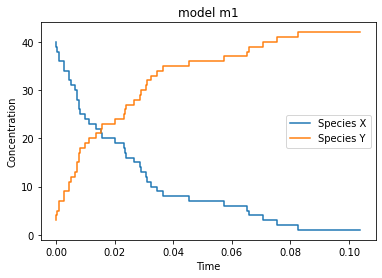

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt

observations_m1 = Model_m1()({"rate": 1.5})
axes = plt.axes()
axes.step(observations_m1["t"], observations_m1["X"]);
axes.legend(["Species X", "Species Y"]);
axes.set_xlabel("Time");
axes.set_ylabel("Concentration");
axes.set_title("model m1");

We observe that species $X$ is converted into species $Y$ in both cases.
The difference of the concentrations over time can be quite subtle.

We define a distance function as $L_1$ norm of two trajectories, evaluated at 20 time points:

$$
  \mathrm{distance}(X_1, X_2) =
     \frac{1}{N}\sum_{n=1}^{N} 
           \left  |X_1(t_n) -X_2(t_n) 
           \right|, \quad t_n = \frac{n}{N}T, \quad  N=20 \,.
$$

Note that we only consider the concentration of species $Y$ for distance calculation. And in code:

In [109]:
N_TEST_TIMES = 20

t_test_times = np.linspace(0, MAX_T, N_TEST_TIMES)
def distance(x, y):
    xt_ind = np.searchsorted(x["t"], t_test_times) - 1
    yt_ind = np.searchsorted(y["t"], t_test_times) - 1
    error = (np.absolute(x["X"][:,1][xt_ind]
                        - y["X"][:,1][yt_ind]).sum()
             / t_test_times.size)
    return error


For ABC, we choose a uniform prior over the interval $[-1, 4]$ for the rate parameters:

In [110]:
from pyabc import Distribution, RV

prior = Distribution(rate=RV("uniform",-1, 4))


We initialize the ABCSMC class passing model $m_1$, its prior and the distance function.

In [ ]:
from pyabc import ABCSMC

abc = ABCSMC(Model_m1(),
             prior,
             distance,
             population_size=200)


We initialize a new ABC run, taking as observed data the one generated by model $m1$.
The ABC run is to be stored in the sqlite database located at ``/tmp/mjp.db``.

In [ ]:
abc_id = abc.new("sqlite:////tmp/mjp.db", observations_m1)


We start pyABC which automatically parallelizes across all available cores.

In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=11)


lets inspect the distribution of the rate parameter for model $m_1$



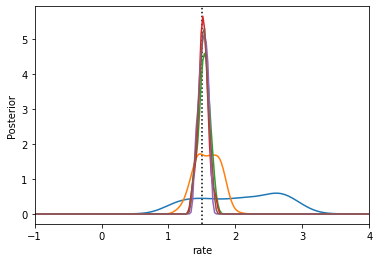

In [115]:
from pyabc.visualization import plot_kde_1d
import math
axes = plt.axes()

axes.axvline(1.5, color="black", linestyle="dotted")
for t in range(0, history.n_populations, 2):
    df, w = history.get_distribution(t=t)
    if len(w) > 0:  # Particles in a model might die out
        plot_kde_1d(df, w, "rate", ax=axes, label=f"t={t}",
                    xmin=-1, xmax=4,
                    numx=200)


The true rate is a little harder to interpret over the posterior over model $m_1$. Apparently a rate between 1.2 and 1.8 yields data most similar to the observed data. The dash line represents the true parameter ($k1=1.5$)



Now, lets consider another Markov jump process models $m_2$ for the same conversion of the chemical species:

$$
  m_2: X + Y \xrightarrow{k_2} 2Y\\
$$


Model $m_2$ inherits the initial concentration from model $m_1$.
The reaction $X + Y \xrightarrow{k_2} 2Y$ is incoded in ``pre = [[1, 1]]`` and ``post = [[0, 2]]``.

In [74]:
class Model_m2(Model_m1):
    __name__ = "Model 2"
    pre = np.array([[1, 1]], dtype=int)
    post = np.array([[0, 2]])
    scale="log10"

Now, lets draw one stochastic simulation from both models side by side using different rates for $k1=1.5$ and $k2=0.3617$.

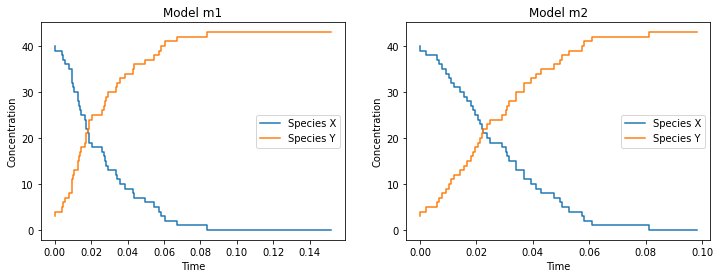

In [91]:
observations = [Model_m1()({"rate": 1.5}),
                Model_m2()({"rate": 0.3617})]
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches((12, 4))
for ax, title, obs in zip(axes, ["Model m1", "Model m2"],
                          observations):
    ax.step(obs["t"], obs["X"]);
    ax.legend(["Species X", "Species Y"]);
    ax.set_xlabel("Time");
    ax.set_ylabel("Concentration");
    ax.set_title(title);


We observe that species $X$ is converted into species $Y$ in both cases.
The difference of the concentrations over time can be quite subtle.



Next, lets initialize the ABCSMC class again by passing the two models ($m_1$ and $m_2$), their priors and the same distance function as before.

In [119]:
from pyabc.populationstrategy import AdaptivePopulationSize

abc = ABCSMC([Model_m1(),
              Model_m2()],
             [prior, prior],
             distance,
             population_size=AdaptivePopulationSize(500, 0.12))


INFO:Sampler:Parallelizing the sampling on 12 cores.


This time, we will initialize a new ABC run, taking as observed data the one generated by model $m2$.
The ABC run is to be stored in the same database located at ``/tmp/mjp.db``.

In [120]:
abc_id = abc.new("sqlite:////tmp/mjp.db", observations[1])

INFO:History:Start <ABCSMC(id=22, start_time=2020-10-04 13:18:53.709949, end_time=None)>


In [121]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=12)


INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 10.85
INFO:ABC:t: 0, eps: 10.85.
INFO:ABC:Acceptance rate: 500 / 878 = 5.6948e-01, ESS=5.0000e+02.
INFO:Adaptation:Change nr particles 500 -> 203
INFO:ABC:t: 1, eps: 10.124999999999991.
INFO:ABC:Acceptance rate: 203 / 417 = 4.8681e-01, ESS=1.8016e+02.
INFO:Adaptation:Change nr particles 203 -> 189
INFO:ABC:t: 2, eps: 6.602678378616124.
INFO:ABC:Acceptance rate: 189 / 392 = 4.8214e-01, ESS=1.7597e+02.
INFO:Adaptation:Change nr particles 189 -> 212
INFO:ABC:t: 3, eps: 4.229175382514021.
INFO:ABC:Acceptance rate: 212 / 413 = 5.1332e-01, ESS=1.9946e+02.
INFO:Adaptation:Change nr particles 212 -> 221
INFO:ABC:t: 4, eps: 2.9.
INFO:ABC:Acceptance rate: 221 / 582 = 3.7973e-01, ESS=1.9149e+02.
INFO:Adaptation:Change nr particles 221 -> 215
INFO:ABC:t: 5, eps: 2.2.
INFO:ABC:Acceptance rate: 215 / 1015 = 2.1182e-01, ESS=1.9564e+02.
INFO:Adaptation:Change nr particles 215 -> 200
INFO:ABC:t: 6, eps: 1.85.
INFO:ABC:Acceptance ra

We first inspect the model probabilities.


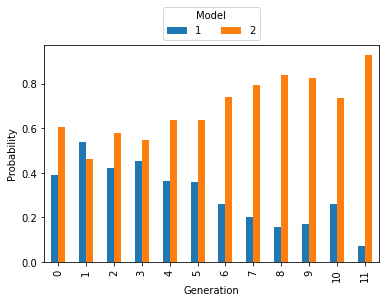

In [122]:
ax = history.get_model_probabilities().plot.bar();
ax.set_ylabel("Probability");
ax.set_xlabel("Generation");
ax.legend([1, 2], title="Model", ncol=2,
          loc="lower center", bbox_to_anchor=(.5, 1));


The mass at model $m2$ increased, the mass at model $m1$ decreased slowly.
The correct model $m2$ is detected towards the later generations.
We then inspect the distribution of the rate parameters:

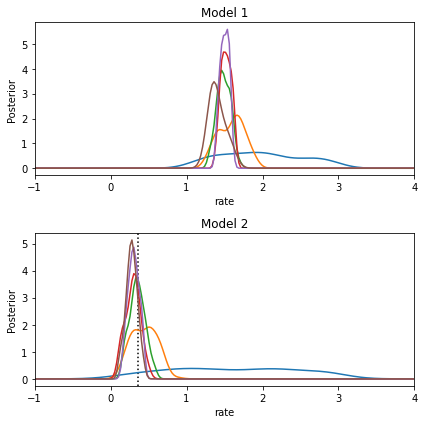

In [131]:
from pyabc.visualization import plot_kde_1d
fig, axes = plt.subplots(2)
fig.set_size_inches((6, 6))
axes[1].axvline(0.3617, color="black", linestyle="dotted")

for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 2):
        df, w = history.get_distribution(m=m, t=t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, "rate", ax=ax, label=f"t={t}",
                        xmin=-1, xmax=4,
                        numx=200)
    ax.set_title(f"Model {m+1}")

fig.tight_layout()

The true rate is closely approximated by the posterior over the rate of model $m2$.
It is a little harder to interpret the posterior over model $m1$.
Apparently a rate between 20 and 40 yields data most similar to the observed data.

Lastly, pyABC also offers various other visualization routines in order to analyze the parameter estimation run:

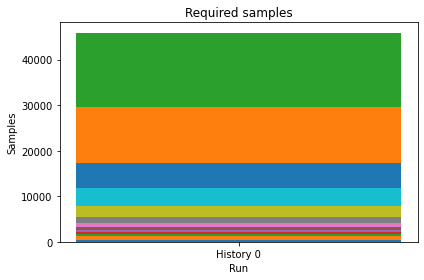

In [132]:
from pyabc import visualization



ax = visualization.plot_sample_numbers(history)


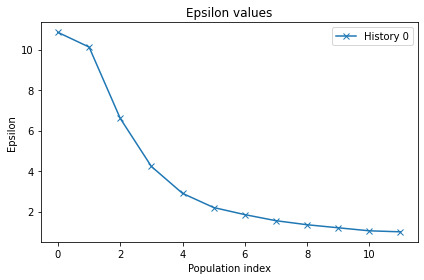

In [133]:
ax = visualization.plot_epsilons(history)



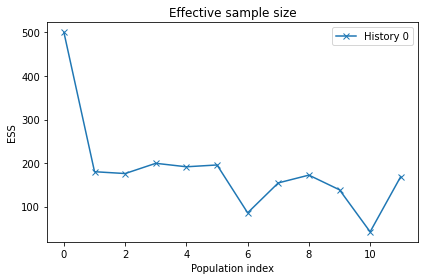

In [134]:
ax = visualization.plot_effective_sample_sizes(history)


The initially chosen population size was adapted to the desired target accuracy.
A larger population size was automatically selected by pyABC while both models were still alive. The population size decreased during the later populations thereby saving computational time.